# Dask

[Dask](https://dask.org/) is a library for parallel processing in Python, with a specific focus on analytic and scientific computing. Compared to Spark, it is more familiar to Python-oriented data scientists. In this notebook, we'll spin up an ad-hoc Dask cluster on top of CML sessions using the CML [Workers API](https://docs.cloudera.com/machine-learning/cloud/distributed-computing/topics/ml-workers-api.html).

## Set up a Dask cluster

In [1]:
!pip3 install dask[complete] dask-ml

In [2]:
import os
import time

import cdsw
import dask
import dask.array as da
import dask.dataframe as dd
import dask_ml as dm
import dask_ml.datasets
import dask_ml.linear_model

from dask.distributed import Client

### Start Dask scheduler
We need to make two directories required by Dask. Dask uses these directories to share network information between the scheduler and workers. From our, user, perspective, we can create them and forget them.

In [3]:
os.makedirs("_scheduler_", exist_ok=True)
os.makedirs("_worker_", exist_ok=True)

We start a Dask scheduler as a CDSW worker process. We do this with cdsw.launch_workers, which spins up another session on our cluster and runs the command we provide — in this case the Dask scheduler. The scheduler is responsible for coordinating work between the Dask workers we will attach. Later we'll start a Dask client in this notebook. The client talks to the scheduler, and the scheduler talks to the workers.

In [4]:
dask_scheduler = cdsw.launch_workers(
  n=1,
  cpu=1,
  memory=2,
  code=f"!dask-scheduler --host 0.0.0.0 --dashboard-address 127.0.0.1:8090 --scheduler-file /home/cdsw/_scheduler_/dask.log"
)

# Wait for the scheduler to start.
time.sleep(10)

We need the IP address of the CML worker with the scheduler on it, so we can connect the Dask workers to it. The IP is not returned in the dask_scheduler object (it's unknown at the launch of the scheduler), so we scan through the worker list and find the IP of the worker with the scheduler id. This returns a list, but there should be only one entry.

In [5]:
scheduler_workers = cdsw.list_workers()
scheduler_id = dask_scheduler[0]['id']
scheduler_ip = [worker['ip_address'] for worker in scheduler_workers
                if worker['id'] == scheduler_id][0]

scheduler_url = f"tcp://{scheduler_ip}:8786"

scheduler_url

'tcp://100.100.154.234:8786'

### Start Dask workers
We're ready to grow our cluster. We start some more CML workers, each with one Dask worker process on it. We pass the scheduler URL we just found so that the scheduler can talk, and distribute work, to the workers.

N_WORKERS determines the number of CML workers started (and thus the number of Dask workers running in those sessions). Increasing the number will start more workers. This will speed up the wall-clock time of the TPOT training process, by training more pipelines in parallel, but it uses more cluster resources. Exercise good judgement.

In [6]:
N_WORKERS = 3

In [7]:
dask_workers = cdsw.launch_workers(
  n=N_WORKERS,
  cpu=1,
  memory=2,
  code=f"!dask-worker {scheduler_url} --local-directory /home/cdsw/_worker_"
)

# Wait for the workers to start.
time.sleep(10)

### Connect Dask client
We have a Dask cluster running and distributed over CML sessions. Now we can start a local Dask client and connect it to our scheduler. This is the connection that lets us issue instructions to the Dask cluster.

In [8]:
client = Client(scheduler_url)

We can view some stats about the Dask cluster.

In [9]:
client

Connection method: Direct,
Dashboard: http://100.100.154.234:8090/status,
Comm: tcp://100.100.154.234:8786,Workers: 0
Dashboard: http://100.100.154.234:8090/status,Total threads: 0
Started: Just now,Total memory: 0 B


The Dask scheduler hosts a dashboard so we can monitor the work it's doing. Here we construct the URL of dashboard, which is hosted on the scheduler worker. Clicking it should open the dashboard in a new browser window.

In [10]:
print("//".join(dask_scheduler[0]["app_url"].split("//"))+ "status")

https://pz7lafm5yh9g8vc1.ml-59f361b4-aac.eng-ml-l.vnu8-sqze.cloudera.site/status


That's our Dask cluster set up, let's do something with it.

## Do some data science!

Dask provides distributed equivalents to several popular and useful libraries in the Python data science ecosystem. Here we'll give a very brief demo of the Dask equivalents of [NumPy](https://numpy.org/) (Dask Array), [Pandas](https://pandas.pydata.org/) (Dask DataFrames), and [scikit-learn](https://scikit-learn.org/stable/) (Dask ML).

### Dask Arrays

We can instantiate a random multidimensional array like so:

In [11]:
array = da.random.random((10_000, 10, 10_000), chunks=1000)
array

dask.array<random_sample, shape=(10000, 10, 10000), dtype=float64, chunksize=(1000, 10, 1000), chunktype=numpy.ndarray>

Notice that this is lazily evaluated: the array would be around 7.5 GiB in memory, but we haven't computed anything yet. The `chunks` parameter controls data layout; above we're splitting it into 1000 chunks. Each chunk is a NumPy array. We can now queue up NumPy-like manipulation on it like so:

In [12]:
# these manipulations do not carry any special meaning
array = (
    da.reshape(array, (10_000, 100_000)) # reshape the array
    .T                                  # transpose it
    [:10, :1000]                    # take only the first 10 elements of the outer axis
)
array

dask.array<getitem, shape=(10, 1000), dtype=float64, chunksize=(10, 1000), chunktype=numpy.ndarray>

Dask even includes parallel versions of much of the NumPy linalg functionality, so we can do, for instance, a singular value decomposition of our transformed array.

In [13]:
u, s, vh = da.linalg.svd(array)

The arrays we just computed with are distributed and lazily evaluated. To access their contents as a NumPy array, we must call `.compute()` explicitly. Be careful not to accidentally bring back an array that is bigger than the session memory, since that will crash the session. This computation will take a little time, and we can see the work happening over in the Dask Dashboard.

In [14]:
s.compute()

array([50.92688281,  9.73143052,  9.55221545,  9.51477276,  9.22616507,
        9.18980337,  8.90806045,  8.73166159,  8.69691546,  8.48387584])

### Dask DataFrames

Dask DataFrames are extremely similar to Pandas DataFrames. In fact, Dask is really just co-ordinating Pandas objects under the hood. As such, we have access to most of the Pandas API, with the caveat that operations will be faster or slower depending on their degree of parallelizability.

In [15]:
# dask provides a handy dataset for demo-ing itself
df = dask.datasets.timeseries()

We can take a peak at the head of the DataFrame, which will return the head of the first Pandas DataFrame in the Dask structure.

In [16]:
df.head()

,id,name,x,y
timestamp,,,,
2000-01-01 00:00:00,1001,Victor,-0.745888,0.398657
2000-01-01 00:00:01,1010,Sarah,0.220209,0.120177
2000-01-01 00:00:02,992,Ray,0.466271,0.822227
2000-01-01 00:00:03,1019,Alice,-0.885496,-0.575574
2000-01-01 00:00:04,1024,Tim,0.888696,0.595129


We can do standard DataFrame operations, like finding the unique values of a column. This is an operation on distributed data, so we must call `.compute()` to collect the result. When we call `.head()`, the result is collected for us.

In [17]:
names = df['name'].unique().values
names.compute()

array(['Victor', 'Sarah', 'Ray', 'Alice', 'Tim', 'Norbert', 'Zelda',
       'Frank', 'Laura', 'Patricia', 'Hannah', 'Ingrid', 'Bob', 'Jerry',
       'Quinn', 'Michael', 'Yvonne', 'Ursula', 'Dan', 'Wendy', 'Edith',
       'George', 'Kevin', 'Xavier', 'Charlie', 'Oliver'], dtype=object)

We can chain operations as usual. Once we've called `.compute()`, we're left with a Pandas DataFrame, and can call regular Pandas methods (like `.plot()`) on it.

(There's no special meaning to the operations below. We're just taking the column-wise cumulative sum of some random numbers for a filtered set of data).

<AxesSubplot:xlabel='timestamp'>

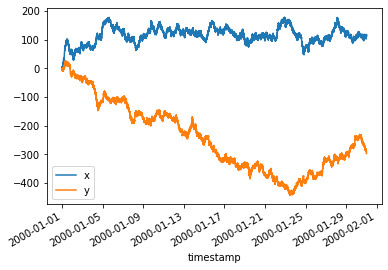

In [18]:
(
    df
    [(df.name == 'Oliver')]
    [['x', 'y']]
    .cumsum()
    .compute()
    .plot()
)

### Dask ML

Dask ML supports several machine learning frameworks, mostly through scikit-learn integration.

First, generate a fake classification dataset.

In [19]:
X, y = dm.datasets.make_classification(
    n_samples=100_000,
    chunks=1000,
    random_state=123)
X = X.persist()
y = y.persist()

And define a logistic regression model with L2 regularization.

In [20]:
lr = dm.linear_model.LogisticRegression()

We can fit that on the distributed Dask dataset.

In [21]:
lr.fit(X, y)

LogisticRegression()

And report our training loss. The trained algorithm is still a Dask object, so we must call `.compute()` to retrieve the number.

In [22]:
lr.score(X, y).compute()

0.67466

## Clean up

Now that we're done computing with our distributed Dask cluster, we should shut down those workers.

In [23]:
cdsw.stop_workers(*[worker["id"] for worker in dask_workers+dask_scheduler])

[<Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>]

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
